# Prepare Colab
**Первичные манипуляции с Colab**

---

1.   присоединение гугл диска
2.   установить необходимую библиотеку (ее необходимо обновить)



1.   connect GDrive
2.   install albumentation (update)



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
pip install -U albumentations

# Подготовка блокнота 
# Prepare notebook


---

In [ ]:
import albumentations as A
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import experimental
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential

import numpy as np
import cv2
import csv
import os
import PIL

from matplotlib import pyplot as plt
from google.colab import files
from google.colab.patches import cv2_imshow

# Аугментация | Augmentation


---



In [ ]:
data = '/content/drive/MyDrive/IPavlov_CV/cats_and_dogs'
train_dir = '/content/drive/MyDrive/IPavlov_CV/cats_and_dogs/train'
train_files = os.listdir(train_dir)
test_dir = '/content/drive/MyDrive/IPavlov_CV/cats_and_dogs/valid'
test_files = os.listdir(test_dir)
os.mkdir(data + '/anno')
csv_path = data + '/anno/'


In [ ]:
def make_augmentation(dir, folder):
  
  os.chdir(dir)
  try:
    os.mkdir('./augmentation')
  except:
    pass
  augmentation_path = dir + '/augmentation'

  for item in folder:
    if '.txt' in item:
      with open(item, 'r') as file:
        for row in file:
          cla = row[0]
          box = row[1:]
          bbox = [int(x) for x in box.split()]
          pic = item[:-4] + '.jpg'
          iter = 1
          # make 3 augm image
          while iter < 4:
            transform(iter, pic, bbox, cla, augmentation_path)
            iter += 1

In [ ]:
def transform(iter, img, box, cla, augmentation_path):
  
  cla = cla
  image = img
  image = cv2.imread(image)
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  #resize and scale bbox
  width, height, _ = image.shape
  NEW_WIDTH = 224
  NEW_HEIGHT = 224

  bbox_scale = box
  bbox = [bbox_scale]
  category_id_to_name = {1: 'cat', 2: 'dog'}

  bbox_params = A.BboxParams(
      format='pascal_voc',
      min_area=0,
      min_visibility=0.5,
      label_fields=['category_ids']
  )
  
  transform = A.Compose([
    A.Resize(NEW_HEIGHT, NEW_WIDTH, always_apply=True),
    A.Rotate(limit=120,p=0.6),
    A.RandomBrightness(limit=0.3),
    A.JpegCompression(quality_lower=85, quality_upper=100, p=0.3),
    A.RandomBrightnessContrast(p=0.2),
    A.GaussNoise(var_limit=(60, 160), mean=90, p=0.4)
    ], bbox_params=bbox_params)
  transformed = transform(image=image, bboxes=bbox, category_ids=cla)
  transformed_image = transformed['image']
  transformed_bboxes = transformed['bboxes']
  transformed_class_labels = transformed['category_ids']

  try:
    data = []
    filename = augmentation_path + '/{}___gen{}.jpg'.format(img[:-4], iter)
    data.append(filename)

    for i in transformed_bboxes[0]:
      data.append(int(i))
    data.append(int(cla))
    if cla == '2': data.append('dog')
    elif cla == '1': data.append('cat')
    data.append('{}___gen{}.jpg'.format(img[:-4], iter))
    # print('DATA\n', data, '\n\n')
    book.append(data)

    cv2.imwrite(filename, transformed_image)

  except:
    print(filename,'was broken')
  

In [ ]:
# write augmentation data to csv
book=[]
make_augmentation(train_dir, train_files)
csv_file = csv_path + 'train_anno.csv'
with open(csv_file, 'w', encoding='UTF8') as document:
    writer = csv.writer(document)
    writer.writerows(book)


/usr/local/lib/python3.7/dist-packages/albumentations/augmentations/transforms.py:1746: FutureWarning: This class has been deprecated. Please use RandomBrightnessContrast
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/albumentations/augmentations/transforms.py:915: FutureWarning: This class has been deprecated. Please use ImageCompression
  FutureWarning,


/content/drive/MyDrive/IPavlov_CV/cats_and_dogs/train/augmentation/Egyptian_Mau_134___gen3.jpg was broken


In [ ]:
# augmentation size
print(len(book))

8954


Тестовые данные оставляем без каких-либо изменений. Т.к. их сетка и не должна видеть.
Только сделаем из них удобную сиэсвешку

Test dataset don't change. Only put in csv file

In [ ]:
book = []
os.chdir(test_dir)
for item in test_files:
    if '.txt' in item:
      with open(item, 'r') as file:
        for row in file:
          cla = int(row[0])
          box = row[1:]
          bbox = [int(x) for x in box.split()]
          pic = item[:-4] + '.jpg'
          filename = test_dir +'/' + pic
          if cla == 1: label='cat'
          elif cla == 2: label='dog'
          data = [filename,bbox[0],bbox[1],bbox[2],bbox[3],cla,label,pic]
          book.append(data)

In [ ]:
# write test data to csv
csv_file = csv_path + 'test_anno.csv'
with open(csv_file, 'w', encoding='UTF8') as document:
    writer = csv.writer(document)
    writer.writerows(book)

In [ ]:
print(len(book))

400


# Подготовка данных для подачи в нейросети
# Preprocessing

---



### Корпус данных для нейронок
### Prepare data to neural network

In [ ]:
train_anno_csv = '/content/drive/MyDrive/IPavlov_CV/cats_and_dogs/anno/train_anno.csv'
test_anno_csv = '/content/drive/MyDrive/IPavlov_CV/cats_and_dogs/anno/test_anno.csv'

In [ ]:
train_cla = []
train_bbox = []
train_image=[]


with open(train_anno_csv, 'r') as csv_f:
  for row in csv_f:
    row = row.split(',')
    fname, x1, y1, x2, y2, cla, lab, img_name = row

    x1 = int(x1.strip())
    y1 = int(y1.strip())
    x2 = int(x2.strip())
    y2 = int(y2.strip())
    train_bbox.append((round(x1/224, 2),
                       round(y1/224, 2), 
                       round(x2/224, 2), 
                       round(y2/224, 2)))
    cla = int(cla.strip())
    if cla == 1: train_cla.append(0)
    elif cla == 2: train_cla.append(1)

    image = load_img(fname)
    img_arr = img_to_array(image)
    train_image.append(img_arr)


In [ ]:
print(len(train_image))
# 8954
print(train_bbox[0])
print(train_cla[0])

8954
(0.04, 0.31, 0.54, 0.68)
1


In [ ]:
test_cla = []
test_bbox = []
test_image = []

with open(test_anno_csv, 'r') as csv_f:
  for row in csv_f:
    row = row.split(',')
    fname, x1, y1, x2, y2, cla, lab, img_name = row
    
    # rescale bbox
    img = PIL.Image.open(fname)
    width, height = img.size
    x1 = int(x1.strip())
    y1 = int(y1.strip())
    x2 = int(x2.strip())
    y2 = int(y2.strip())
    test_bbox.append((round(x1 / width, 2), 
                      round(y1 / height, 2), 
                      round(x2 / width, 2), 
                      round(y2 / height, 2)))
    cla = int(cla.strip())
    if cla == 1: test_cla.append(0)
    elif cla == 2: test_cla.append(1)

    image = load_img(fname, target_size=(224,224))
    img_arr = img_to_array(image)
    test_image.append(img_arr)
    

In [ ]:
print(train_bbox[3])
print(test_bbox[3])

[0.02 0.08 0.88 0.74]
[0.06 0.   0.9  0.93]


In [ ]:
print(test_bbox[0])
print(test_cla[0])
print(test_image[10].shape)
print(test_image[3])

In [ ]:
# memory out
# need less data
train_image = np.array(train_image[:4000])
train_bbox = np.array(train_bbox[:4000])
train_cla = np.array(train_cla[:4000])

test_image = np.array(test_image)
test_bbox = np.array(test_bbox)
test_cla = np.array(test_cla)

# Создание и обучение custom CNN
# Create and train custom CNN

---


In [ ]:
image_input = Input(shape=(224, 224, 3), name='input_image')
x = experimental.preprocessing.Rescaling(1./255, name='rescale')(image_input)
x = Conv2D(32, (3,3), padding='same', activation='relu', name='conv_1')(x)
x = MaxPooling2D(name='max_1')(x)
x = Conv2D(32, (3,3), padding='same', activation='relu', name='conv_2')(x)
x = MaxPooling2D(name='max_2')(x)
x = Conv2D(64, (3,3), padding='same', activation='relu', name='conv_3')(x)
x = MaxPooling2D(name='max_3')(x)
x = Conv2D(128, (3,3), padding='same', activation='relu', name='conv_4')(x)
x = MaxPooling2D(name='max_4')(x)
x = Conv2D(128, (3,3), padding='same', activation='relu', name='conv_5')(x)
x = MaxPooling2D(name='max_5')(x)
flat = Flatten(name='Flatten')(x)

box = Dense(128, activation='relu', name='box_1')(flat)
box = Dense(64, activation='relu', name='box_2')(box)
box = Dense(32, activation='relu', name='box_3')(box)
box = Dense(16, activation='relu', name='box_4')(box)
box = Dense(4, activation='sigmoid', name='box_5')(box)

index = Dense(128, activation='relu', name='index_1')(flat)
index = Dense(128, activation='relu', name='index_2')(index)
index = Dense(64, activation='relu', name='index_3')(index)
index = Dense(1, activation='sigmoid', name='index_4')(index)


model = Model(inputs=image_input,
              outputs=[box, index])

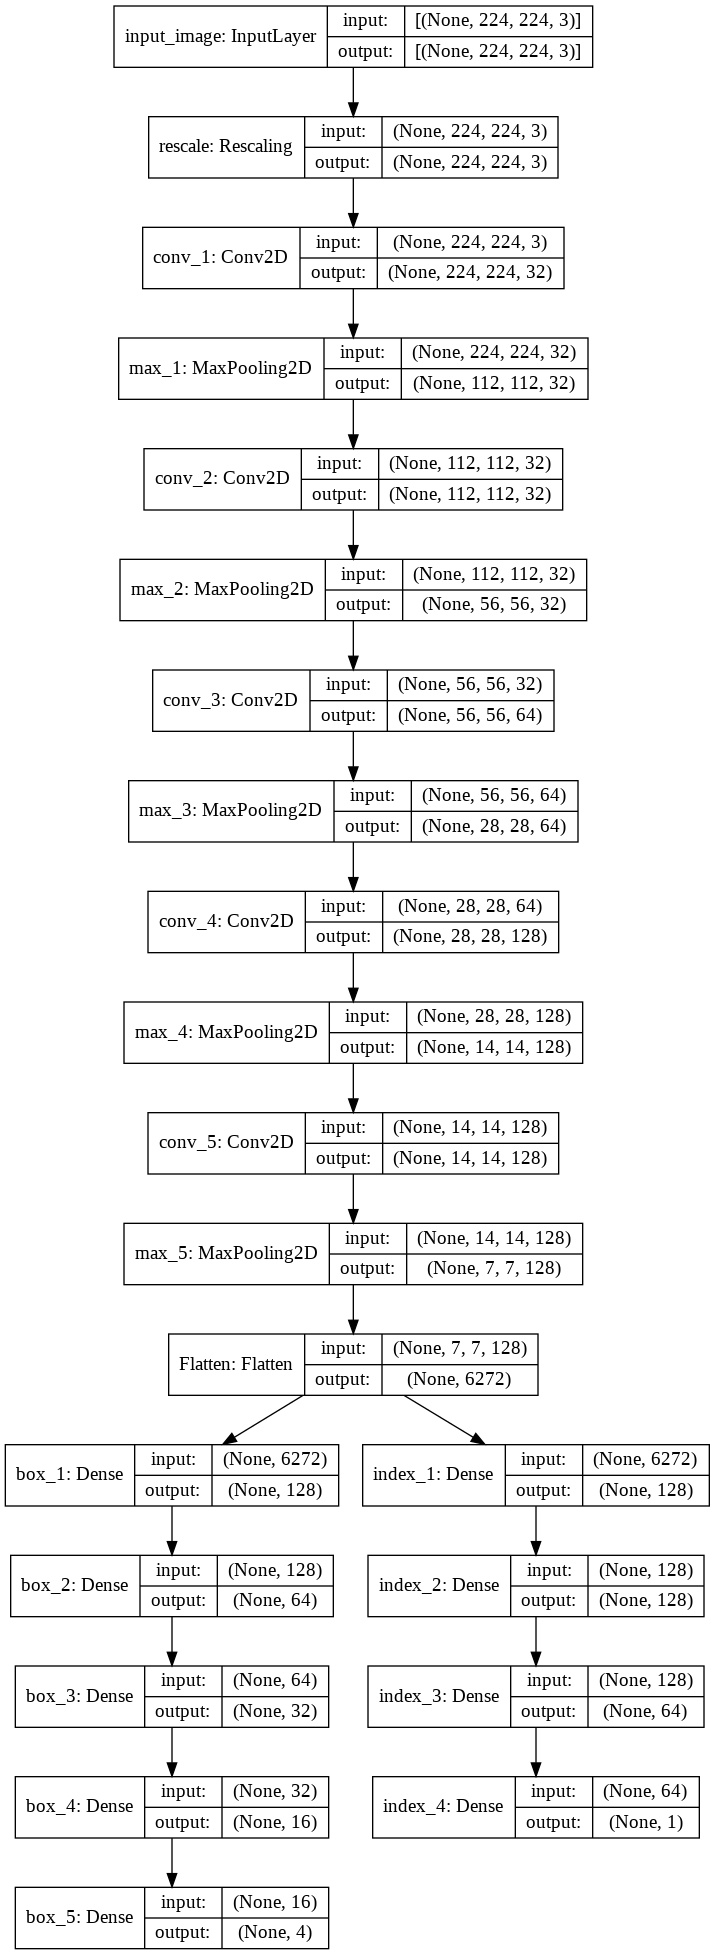

In [ ]:
tf.keras.utils.plot_model(model, "/content/drive/MyDrive/IPavlov_CV_models/Custom_detection_CNN.png", show_shapes=True)


In [ ]:
losses = {'box_5':tf.keras.losses.MSE,
          'index_4':tf.keras.losses.BinaryCrossentropy()}
metrices = {'box_5':tf.keras.metrics.MeanIoU(num_classes=2),
          'index_4':tf.keras.metrics.BinaryAccuracy()}
optim = tf.keras.optimizers.Adam()
model.compile(optimizer=optim,
              loss=losses,
              metrics=metrices)

print(model.summary())

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_image (InputLayer)        [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
rescale (Rescaling)             (None, 224, 224, 3)  0           input_image[0][0]                
__________________________________________________________________________________________________
conv_1 (Conv2D)                 (None, 224, 224, 32) 896         rescale[0][0]                    
__________________________________________________________________________________________________
max_1 (MaxPooling2D)            (None, 112, 112, 32) 0           conv_1[0][0]                     
______________________________________________________________________________________________

In [ ]:
train_targets = {'box_5':train_bbox,
                 'index_4':train_cla}

test_targets = {'box_5':test_bbox,
                'index_4':test_cla}
                

In [ ]:
history = model.fit(
    train_image, train_targets,
    validation_data=(test_image, test_targets),
    epochs=15, 
    batch_size=64
)

Epoch 1/15
63/63 [==============================] - 39s 103ms/step - loss: 0.6441 - box_5_loss: 0.0409 - index_4_loss: 0.6032 - box_5_mean_io_u: 0.4876 - index_4_binary_accuracy: 0.7170 - val_loss: 0.6293 - val_box_5_loss: 0.0238 - val_index_4_loss: 0.6054 - val_box_5_mean_io_u: 0.4975 - val_index_4_binary_accuracy: 0.6850
Epoch 2/15
63/63 [==============================] - 5s 79ms/step - loss: 0.6221 - box_5_loss: 0.0287 - index_4_loss: 0.5935 - box_5_mean_io_u: 0.4876 - index_4_binary_accuracy: 0.7172 - val_loss: 0.6371 - val_box_5_loss: 0.0224 - val_index_4_loss: 0.6147 - val_box_5_mean_io_u: 0.4975 - val_index_4_binary_accuracy: 0.6850
Epoch 3/15
63/63 [==============================] - 5s 80ms/step - loss: 0.6201 - box_5_loss: 0.0275 - index_4_loss: 0.5926 - box_5_mean_io_u: 0.4876 - index_4_binary_accuracy: 0.7172 - val_loss: 0.6472 - val_box_5_loss: 0.0330 - val_index_4_loss: 0.6142 - val_box_5_mean_io_u: 0.4975 - val_index_4_binary_accuracy: 0.6850
Epoch 4/15
63/63 [===========

In [ ]:
#save model
tf.keras.models.save_model(model, save_format='h5', filepath='/content/drive/MyDrive/IPavlov_CV_models/new_myCNN.h5')

In [ ]:
acc = history.history['index_4_binary_accuracy']
val_acc = history.history['val_index_4_binary_accuracy']
miou = history.history['box_5_mean_io_u']
val_miou = history.history['val_box_5_mean_io_u']

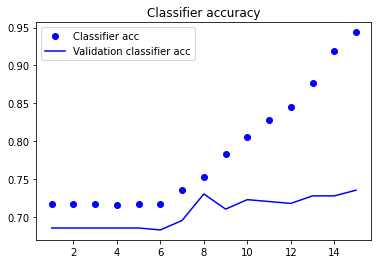

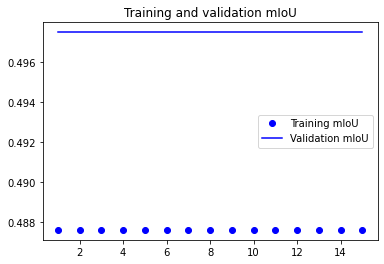

In [ ]:
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Classifier acc')
plt.plot(epochs, val_acc, 'b', label='Validation classifier acc')
plt.title('Classifier accuracy')
plt.legend()
plt.savefig('/content/drive/MyDrive/IPavlov_CV_models/small_Custom_CNN_acc.png', dpi=500, facecolor='white')
plt.figure()

plt.plot(epochs, miou, 'bo', label='Training mIoU')
plt.plot(epochs, val_miou, 'b', label='Validation mIoU')
plt.title('Training and validation mIoU')
plt.legend()
plt.savefig('/content/drive/MyDrive/IPavlov_CV_models/small_Custom_CNN_mIoU.png', dpi=500, facecolor='white')

plt.show()

# Создание  и  обучение  сети  с  применением  transfer learning
# Create and train neural network with transfer learning
---

In [ ]:
from tensorflow.keras.applications import VGG16

In [ ]:
vgg = VGG16(weights="imagenet", include_top=False,
	input_tensor=Input(shape=(224, 224, 3)))
vgg.trainable = False
flatten = vgg.output
flatten = Flatten()(flatten)

58900480/58889256 [==============================] - 0s 0us/step


In [ ]:
bbox = Dense(128, activation="relu")(flatten)
bbox = Dense(64, activation="relu")(bbox)
bbox = Dense(32, activation="relu")(bbox)
bbox = Dense(4, activation="sigmoid",
	name="bounding_box")(bbox)

In [ ]:
classifier = Dense(512, activation="relu")(flatten)
classifier = Dense(512, activation="relu")(classifier)
classifier = Dense(1, activation="sigmoid",
	name="class_label")(classifier)

In [ ]:
model = Model(
	inputs=vgg.input,
	outputs=(bbox, classifier))

print(model.summary())

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 224, 224, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 224, 224, 64) 36928       block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_pool (MaxPooling2D)      (None, 112, 112, 64) 0           block1_conv2[0][0]               
____________________________________________________________________________________________

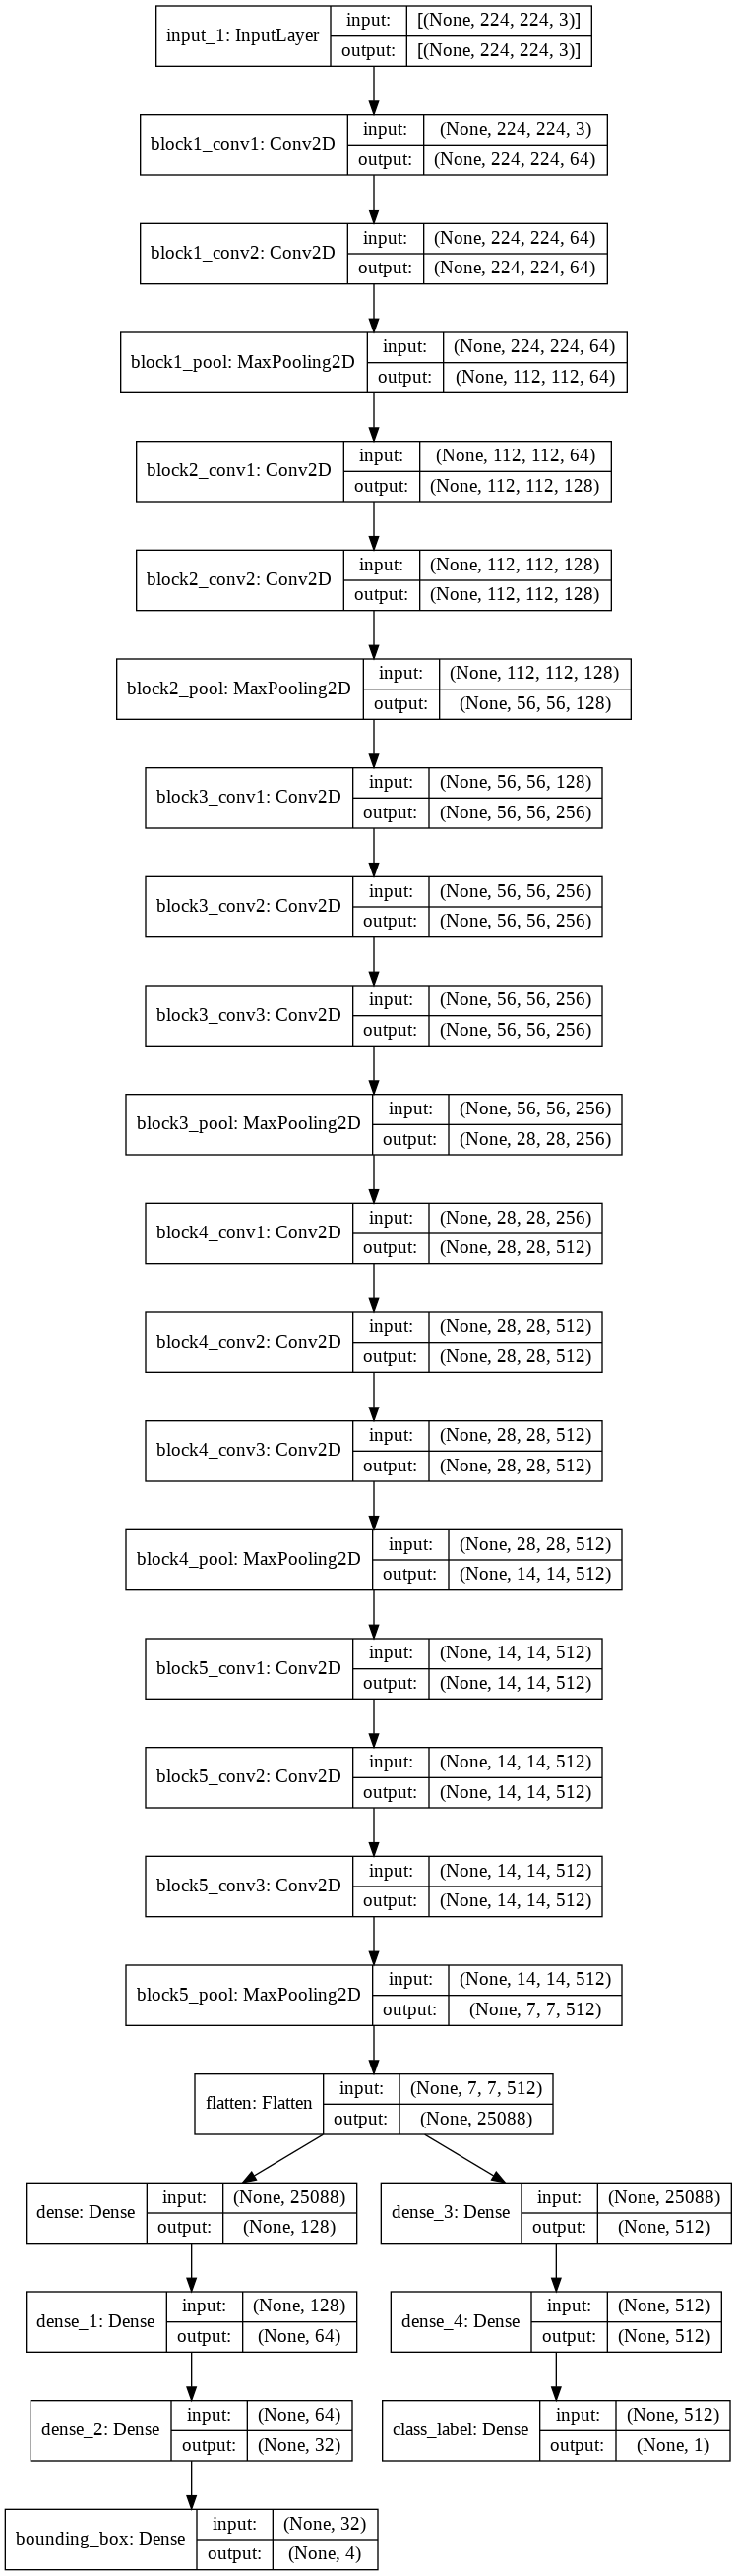

In [ ]:
tf.keras.utils.plot_model(model, "/content/drive/MyDrive/IPavlov_CV_models/Transfer_detection_VGG16.png", show_shapes=True)

In [ ]:
losses = {"bounding_box":tf.keras.losses.MSE,
          "class_label":tf.keras.losses.BinaryCrossentropy()}

metrices = {"bounding_box":tf.keras.metrics.MeanIoU(num_classes=2),
          "class_label":tf.keras.metrics.BinaryAccuracy()}

opt = tf.keras.optimizers.Adam()
model.compile(loss=losses, optimizer=opt, metrics=metrices)

In [ ]:
train_targets = {"bounding_box":train_bbox,
                 "class_label":train_cla}

test_targets = {"bounding_box":test_bbox,
                "class_label":test_cla}
                

In [ ]:
history = model.fit(
    train_image, train_targets,
    validation_data=(test_image, test_targets),
    epochs=15, 
    batch_size=64
)

Epoch 1/15
63/63 [==============================] - 37s 421ms/step - loss: 3.8213 - bounding_box_loss: 0.0975 - class_label_loss: 3.7238 - bounding_box_mean_io_u_1: 0.2870 - class_label_binary_accuracy: 0.8543 - val_loss: 0.7662 - val_bounding_box_loss: 0.1109 - val_class_label_loss: 0.6553 - val_bounding_box_mean_io_u_1: 0.2563 - val_class_label_binary_accuracy: 0.9450
Epoch 2/15
63/63 [==============================] - 17s 273ms/step - loss: 0.3253 - bounding_box_loss: 0.0944 - class_label_loss: 0.2309 - bounding_box_mean_io_u_1: 0.2812 - class_label_binary_accuracy: 0.9668 - val_loss: 0.6180 - val_bounding_box_loss: 0.1109 - val_class_label_loss: 0.5071 - val_bounding_box_mean_io_u_1: 0.2563 - val_class_label_binary_accuracy: 0.9375
Epoch 3/15
63/63 [==============================] - 18s 280ms/step - loss: 0.1291 - bounding_box_loss: 0.0944 - class_label_loss: 0.0347 - bounding_box_mean_io_u_1: 0.2812 - class_label_binary_accuracy: 0.9902 - val_loss: 0.6950 - val_bounding_box_loss: 

In [ ]:
tf.keras.models.save_model(model, save_format='h5', filepath='/content/drive/MyDrive/IPavlov_CV_models/small_transfer_learn_CNN.h5')

In [ ]:
acc = history.history['class_label_binary_accuracy']
val_acc = history.history['val_class_label_binary_accuracy']
miou = history.history['bounding_box_mean_io_u_1']
val_miou = history.history['val_bounding_box_mean_io_u_1']

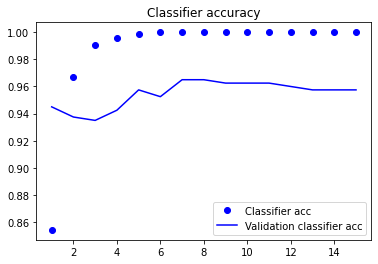

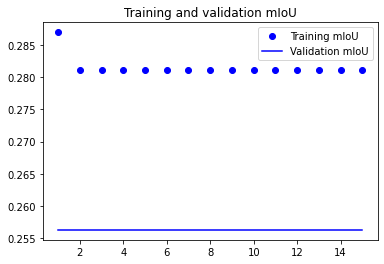

In [ ]:
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Classifier acc')
plt.plot(epochs, val_acc, 'b', label='Validation classifier acc')
plt.title('Classifier accuracy')
plt.legend()
plt.savefig('/content/drive/MyDrive/IPavlov_CV_models/small_Transfer_VGG16_CNN_acc.png', dpi=500, facecolor='white')
plt.figure()

plt.plot(epochs, miou, 'bo', label='Training mIoU')
plt.plot(epochs, val_miou, 'b', label='Validation mIoU')
plt.title('Training and validation mIoU')
plt.legend()
plt.savefig('/content/drive/MyDrive/IPavlov_CV_models/small_Transfer_VGG16_CNN_mIoU.png', dpi=500, facecolor='white')

plt.show()

# Предсказание
# Prediction

---




In [ ]:
def pred(model):
  uploaded = files.upload()

  for fn in uploaded.keys():
    path = '/content/' + fn
    img = tf.keras.preprocessing.image.load_img(path, target_size=(224, 224))
    t_img = img_to_array(img) / 255.0
    t_img = np.expand_dims(t_img, axis=0)
    (bbox, cla) = model.predict(t_img)
    print('box: ',bbox,'\nclass:',cla)
    (x_min, y_min, x_max, y_max) = bbox[0]
    if cla<0.5: label='cat'
    elif cla>=0.5: label='dog'
    print('label:', label)
    plot_bbox(path, bbox, label)

In [ ]:
def plot_bbox(image, bbox, label):
  pic = cv2.imread(image)
  (h, w) = pic.shape[:2]
  #print('h:',h,'w:',w)
  # scale bbox
  startX = int(bbox[0][0] * w)
  startY = int(bbox[0][1] * h)
  endX = int(bbox[0][2] * w)
  endY = int(bbox[0][3] * h)
  print('scale bbox:({}, {}, {}, {})'.format(startX, startY, endX, endY))
	# draw the predicted bounding box and class label on the image
  y = startY - 10 if startY - 10 > 10 else startY + 10
  cv2.putText(pic, label, (startX, y), cv2.FONT_HERSHEY_SIMPLEX,
              0.65, (0, 255, 0), 2)
  cv2.rectangle(pic, (startX, startY), (endX, endY),
                (0, 255, 0), 2)
	# show the output image
  cv2_imshow(pic)

1 - custom_CNN_model
2 - transfer_CNN_model
0 - exit
1


Saving Dogs_05.jpg to Dogs_05 (2).jpg
box:  [[0.16470696 0.0811855  0.8022506  0.6858264 ]] 
class: [[0.49104]]
label: cat
scale bbox:(168, 55, 821, 467)


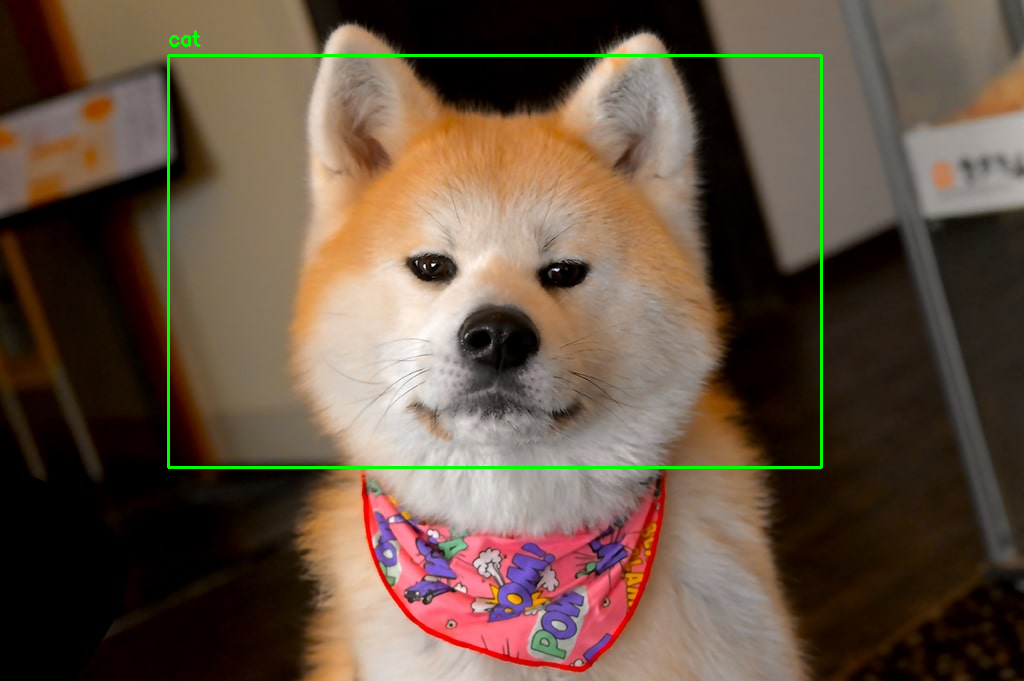

1 - custom_CNN_model
2 - transfer_CNN_model
0 - exit
2


Saving Dogs_05.jpg to Dogs_05 (3).jpg
box:  [[4.6357550e-06 1.1812996e-10 1.0000000e+00 1.0000000e+00]] 
class: [[0.5164462]]
label: dog
scale bbox:(0, 0, 1024, 681)


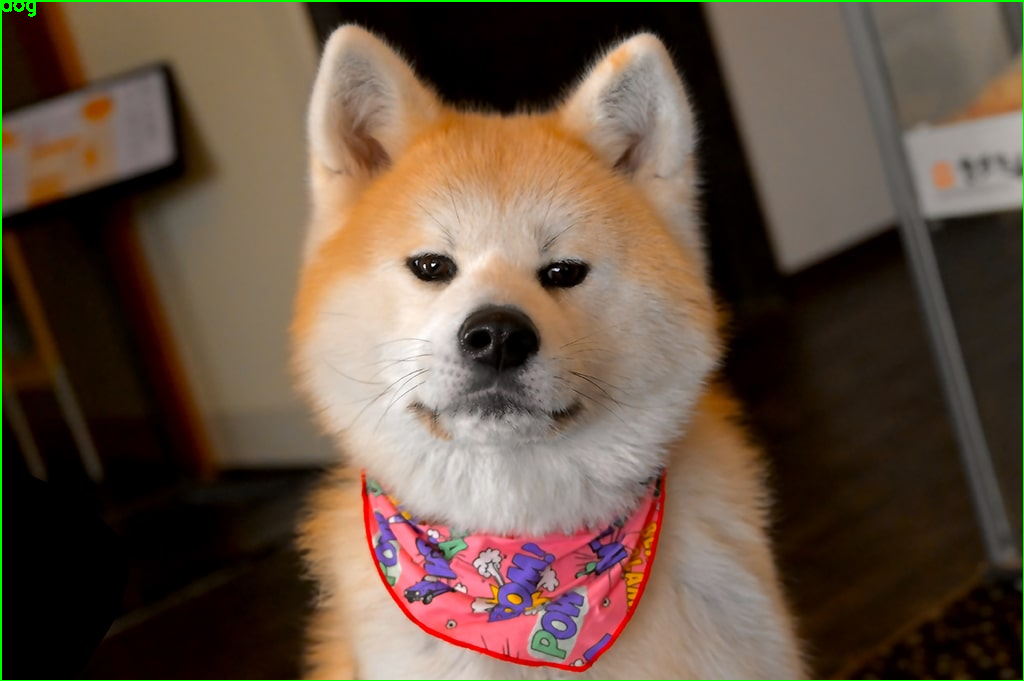

1 - custom_CNN_model
2 - transfer_CNN_model
0 - exit
0


In [ ]:
custom = '/content/drive/MyDrive/IPavlov_CV_models/new_myCNN.h5'
trans = '/content/drive/MyDrive/IPavlov_CV_models/small_transfer_learn_CNN.h5'

while 1:
  word = int(input('1 - custom_CNN_model\n2 - transfer_CNN_model\n0 - exit\n'))
  if word == 1:
    model = tf.keras.models.load_model(custom)
    pred(model)
  elif word == 2:
    model = tf.keras.models.load_model(trans)
    pred(model)
  elif word == 0:
    break
  else:
    print('Wrong! Try again!')